# Import requirements

In [1]:
!pip uninstall datasets -y --quiet

!pip install -U datasets --quiet
!pip install transformers evaluate sentencepiece --quiet
!pip install --upgrade torcheval --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but

In [2]:
import math
import heapq
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import datasets
import sentencepiece as spm
from torcheval.metrics.functional import bleu_score

from tqdm import tqdm


# Load dataset

In [3]:
dataset = datasets.load_dataset("harouzie/vi_en-translation")


README.md:   0%|          | 0.00/665 [00:00<?, ?B/s]

(…)-00000-of-00001-8fc21cb8e80d3a2d.parquet:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

(…)-00000-of-00001-858c0e989d9c5637.parquet:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

(…)-00000-of-00001-99e7e50144d1c164.parquet:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25409 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/25409 [00:00<?, ? examples/s]

In [4]:
train_data, test_data, val_data = dataset['train'], dataset['test'], dataset['valid']

In [5]:
train_data[0]

{'English': "I heard that since Tom isn't feeling well he won't come to school today",
 'Vietnamese': 'tôi nghe nói rằng vì tom không khỏe nên hôm nay anh ấy sẽ không đến trường'}

# Tokenizer

In [6]:
def prepare_tokenizer_train_set(train_data, save_path='train_set.txt'):
    with open(save_path, 'w', encoding='utf-8') as f:
        for pair in tqdm(train_data):
            f.write(pair['English'].strip() + '\n')
            f.write(pair['Vietnamese'].strip() + '\n')
    f.close()
    print(f'Saved to {save_path}')

TRAIN_PATH = 'train_set.txt'
prepare_tokenizer_train_set(train_data, TRAIN_PATH)

100%|██████████| 203272/203272 [00:04<00:00, 44220.59it/s]

Saved to train_set.txt


In [7]:
def train_tokenizer(train_data_path='train_set.txt', model_name='mt_bpe', vocab_size=16000):
    print("Training tokenizer ...")
    spm.SentencePieceTrainer.Train(
        input=train_data_path,
        model_prefix=model_name,
        vocab_size=vocab_size,
        model_type='bpe',
        character_coverage=1.0,
        num_threads=4,
        pad_id=0, unk_id=1, bos_id=2, eos_id=3
    )
    print(f"Trained sentencepiece and saved to {model_name}.model")

MODEL_NAME = '/kaggle/input/sentencepiece-bpe/mt_bpe'
VOCAB_SIZE = 16000

# train_tokenizer(TRAIN_PATH, MODEL_NAME, VOCAB_SIZE)

In [8]:
def load_tokenizer(model_name='mt_bpe'):
    return spm.SentencePieceProcessor(model_file=f'{model_name}.model')

sp = load_tokenizer(MODEL_NAME)

# Encode sang ID
src_ids = sp.encode("I am studying machine translation.", out_type=int)
tgt_ids = sp.encode("Tôi đang học dịch máy.", out_type=int)

print("SRC:", src_ids)
print("TGT:", tgt_ids)


SRC: [27, 700, 2421, 3533, 8337, 15839]
TGT: [151, 186, 372, 2245, 849, 15839]


In [9]:
def encode_with_specials(text, sp):
    ids = sp.encode(text, out_type=int)
    return [sp.bos_id()] + ids + [sp.eos_id()]

src_ids = encode_with_specials("I am studying machine translation.", sp)
tgt_ids = encode_with_specials("Tôi đang học dịch máy.", sp)

print("SRC:", src_ids)
print("TGT:", tgt_ids)

SRC: [2, 27, 700, 2421, 3533, 8337, 15839, 3]
TGT: [2, 151, 186, 372, 2245, 849, 15839, 3]


# Prepare input

In [10]:
class TranslationDataset(Dataset):
    def __init__(self, data, sp):
        self.data = data
        self.sp = sp

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pair = self.data[idx]
        src_ids = encode_with_specials(pair['English'], self.sp)
        tgt_ids = encode_with_specials(pair['Vietnamese'], self.sp)
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_batch, tgt_batch

train_dataset = TranslationDataset(train_data, sp)
test_dataset = TranslationDataset(test_data, sp)
val_dataset = TranslationDataset(val_data, sp)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [11]:
sample_batch = next(iter(train_loader))
print(sample_batch[0].shape)
print(sample_batch[1].shape)
print(sample_batch[0][0])
print(sample_batch[1][0])

torch.Size([32, 23])
torch.Size([32, 20])
tensor([    2,    27,   375, 15850, 15821,   203,    30,  2084,   299,   593,
          351,    84,  4995, 15839,     3,     0,     0,     0,     0,     0,
            0,     0,     0])
tensor([    2,    24,    46,   169,   154,  2188,  1440,   716, 15839,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


# Model

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        PE = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        PE[:, 0::2] = torch.sin(pos * div)
        PE[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('PE', PE.unsqueeze(0))

    def forward(self, x):
        return x + self.PE[:, :x.size(1)]

class MTTransformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model=256,
        nhead=4,
        num_layers=4,
        dim_ff=1024,
        dropout=0.1
    ):
        super().__init__()
        self.d_model = d_model
        self.src_embed = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(d_model, tgt_vocab_size)

    def generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.ones(sz, sz, dtype=torch.bool), diagonal=1)

    def forward(self, src, tgt):
        device = src.device
        src_pad_mask = (src == 0)
        tgt_pad_mask = (tgt == 0)
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(device)

        src = self.pos_enc(self.src_embed(src))
        tgt = self.pos_enc(self.tgt_embed(tgt))

        out = self.transformer(
            src, tgt,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_pad_mask,
            tgt_key_padding_mask=tgt_pad_mask,
            memory_key_padding_mask=src_pad_mask
        )
        return self.fc(out)


model = MTTransformer(
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    d_model=256,
    nhead=8,
    num_layers=6,
    dim_ff=512,
    dropout=0.1
)
# model

In [13]:
model(sample_batch[0], sample_batch[1]).shape

torch.Size([32, 20, 16000])

In [14]:
def count_parameters(model):
	return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 20,212,352 trainable parameters


In [15]:
# preds = model(sample_batch[0], sample_batch[1][..., :-1])
# golds = sample_batch[1][:, 1:]
# print(preds.shape, golds.shape)

# criterion = nn.CrossEntropyLoss(ignore_index=0)
# loss = criterion(preds.reshape(-1, preds.size(-1)), golds.reshape(-1))
# loss

# Training

In [16]:
def train_model(model, dataloader, optimizer, criterion, device, scheduler=None):
    model.train()
    model.to(device)
    total_loss = 0.0

    loop = tqdm(dataloader, unit='batch', desc='\tTraining: ', leave=True)
    for src, tgt in loop:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_gold = tgt[:, 1:]

        logits = model(src, tgt_input)
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_gold.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        
        if scheduler is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
        else:
            optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion, sp, device, n_gram=2):
    model.eval()
    model.to(device)
    total_loss = 0.0
    # all_preds, all_refs = [], []

    with torch.no_grad():
        loop = tqdm(dataloader, unit='batch', desc='\tEvaluating: ', leave=True)
        for src, tgt in loop:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_gold = tgt[:, 1:]

            logits = model(src, tgt_input)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_gold.reshape(-1))
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

            # # Decode ra tokens dạng string
            # preds = logits.argmax(-1).cpu().tolist()
            # golds = tgt_gold.cpu().tolist()
            # for pred_ids, gold_ids in zip(preds, golds):
            #     pred_ids = [i for i in pred_ids if i != sp.pad_id()]
            #     gold_ids = [i for i in gold_ids if i != sp.pad_id()]
            #     print(pred_ids, gold_ids)
            #     break
            
            #     if sp.eos_id() in pred_ids:
            #         pred_ids = pred_ids[:pred_ids.index(sp.eos_id())]
            #     if sp.eos_id() in gold_ids:
            #         gold_ids = gold_ids[:gold_ids.index(sp.eos_id())]
            
            #     # Chỉ giữ lại nếu đủ độ dài để tính n-gram
            #     if len(pred_ids) >= n_gram and len(gold_ids) >= n_gram:
            #         print('OK')
            #         pred_txt = sp.decode(pred_ids)
            #         gold_txt = sp.decode(gold_ids)
            #         all_preds.append(pred_txt)
            #         all_refs.append([gold_txt])

    avg_loss = total_loss / len(dataloader)
    # print(all_preds[:10])
    # print(all_refs[:10])
    # bleu = bleu_score(all_preds, all_refs, n_gram=n_gram, weights=torch.tensor([1.0/n_gram]*n_gram))
    # return avg_loss, bleu.item()
    return avg_loss

#################################################
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = None

# def get_lr(step, d_model=512, warmup_steps=4000):
#     return (d_model ** -0.5) * min(step ** -0.5, step * warmup_steps ** -1.5)

# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: get_lr(step + 1))

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 5

#################################################
train_losses = []
val_losses = []
val_bleus = []
for epoch in range(NUM_EPOCHS):
    torch.cuda.empty_cache()
    print('-----------------------------------------------------------------')
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: ")

    train_loss = train_model(model, train_loader, optimizer, criterion, DEVICE, scheduler)
    # val_loss, val_bleu = evaluate_model(model, val_loader, criterion, sp, DEVICE)
    val_loss = evaluate_model(model, val_loader, criterion, sp, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # val_bleus.append(val_bleu)
    # print(f"\n\t--> Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val BLEU: {val_bleu:.4f}")
    print(f"\n\t--> Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    # print(f"\n\t--> Val Loss: {val_loss:.4f} | Val BLEU: {val_bleu:.4f}")

-----------------------------------------------------------------
Epoch 1/5: 


	Evaluating:   0%|          | 0/795 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
	Evaluating: 100%|██████████| 795/795 [00:16<00:00, 48.26batch/s, loss=4.41]



	--> Train Loss: 3.5923 | Val Loss: 2.4462
-----------------------------------------------------------------
Epoch 2/5: 


	Evaluating: 100%|██████████| 795/795 [00:16<00:00, 48.22batch/s, loss=2.99]



	--> Train Loss: 2.1332 | Val Loss: 1.6455
-----------------------------------------------------------------
Epoch 3/5: 


	Evaluating: 100%|██████████| 795/795 [00:16<00:00, 48.54batch/s, loss=2.81]



	--> Train Loss: 1.5622 | Val Loss: 1.2923
-----------------------------------------------------------------
Epoch 4/5: 


	Evaluating: 100%|██████████| 795/795 [00:16<00:00, 49.06batch/s, loss=2.52]



	--> Train Loss: 1.2561 | Val Loss: 1.0912
-----------------------------------------------------------------
Epoch 5/5: 


	Evaluating: 100%|██████████| 795/795 [00:16<00:00, 48.56batch/s, loss=2.39]


	--> Train Loss: 1.0588 | Val Loss: 0.9628


## Visualize training

In [17]:
torch.save(model.state_dict(), 'best_model.pth')

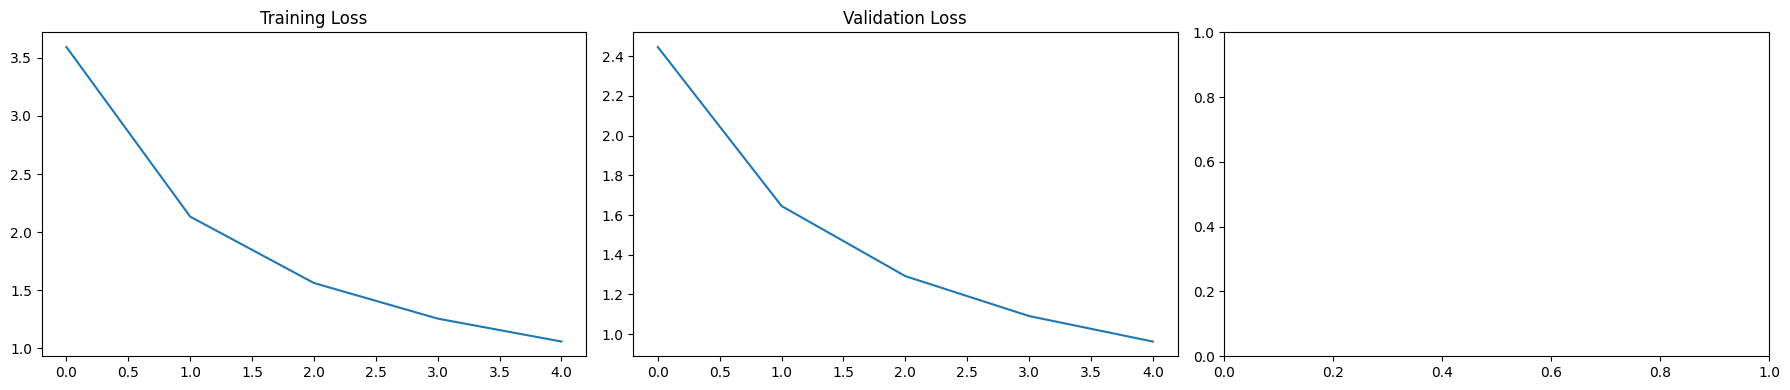

In [18]:
def visualize(
    train_losses, 
    val_losses, 
    # val_bleus
):
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    axs[0].plot(train_losses)
    axs[0].set_title('Training Loss')
    axs[1].plot(val_losses)
    axs[1].set_title('Validation Loss')
    # axs[2].plot(val_bleus)
    # axs[2].set_title('Validation BLEU')
    
    plt.tight_layout()
    plt.show()

visualize(
    train_losses, 
    val_losses, 
    # val_bleus
)

# Inference

In [19]:
def greedy_decode(model, sp, src, max_len=100, device=None):
    device = device or src.device
    model.eval()
    tgt = torch.tensor([[sp.bos_id()]], device=device)
    with torch.no_grad():
        for _ in range(max_len):
            outputs = model(src, tgt)  # (B=1, T_tgt, V)
            next_logit = outputs[:, -1, :]
            next_tok = next_logit.argmax(dim=-1).item()
            tgt = torch.cat([tgt, torch.tensor([[next_tok]], device=device)], dim=1)
            if next_tok == sp.eos_id():
                break
    # Loại bỏ BOS khi decode
    return tgt[0].tolist()

def beam_search_decode(model, sp, src, beam_width=5, max_len=100, device=None):
    device = device or src.device
    model.eval()
    Beam = [([sp.bos_id()], 0.0)]
    with torch.no_grad():
        for _ in range(max_len):
            candidates = []
            for seq, score in Beam:
                if seq[-1] == sp.eos_id():
                    candidates.append((seq, score))
                    continue
                tgt = torch.tensor([seq], device=device)
                outputs = model(src, tgt)
                logp = F.log_softmax(outputs[:, -1, :], dim=1).squeeze(0)
                topk = logp.topk(beam_width)
                for tok, lp in zip(topk.indices.tolist(), topk.values.tolist()):
                    candidates.append((seq + [tok], score + lp))
            Beam = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]
            if all(seq[-1] == sp.eos_id() for seq, _ in Beam):
                break
    return Beam[0][0]

def translate_sentence(sentence, model, sp, beam_width=5, max_len=100, mode='beam', device=None):
    device = device or next(model.parameters()).device
    ids = sp.encode(sentence, out_type=int)
    src = torch.tensor([[sp.bos_id()] + ids + [sp.eos_id()]], device=device)
    seq = beam_search_decode(model, sp, src, beam_width, max_len, device) if mode=='beam' \
          else greedy_decode(model, sp, src, max_len, device)
    # Loại bỏ BOS khi decode
    if seq[0] == sp.bos_id():
        seq = seq[1:]
    # Loại bỏ EOS nếu có
    if sp.eos_id() in seq:
        seq = seq[:seq.index(sp.eos_id())]
    return sp.decode(seq)

def evaluate_test(test_loader, model, sp, beam_width=5, max_len=100, n_gram=2, device=None):
    device = device or next(model.parameters()).device
    model.to(device).eval()
    cand, ref = [], []

    with torch.no_grad():
        for src, tgt in test_loader:
            src, tgt = src.to(device), tgt.to(device)
            for i in range(src.size(0)):
                seq = beam_search_decode(model, sp, src[i:i+1], beam_width, max_len, device)
                # Loại bỏ BOS/EOS khi decode
                if seq[0] == sp.bos_id():
                    seq = seq[1:]
                if sp.eos_id() in seq:
                    seq = seq[:seq.index(sp.eos_id())]
                cand.append(sp.decode(seq))
                ids = [tok for tok in tgt[i].tolist() if tok not in (sp.pad_id(), sp.eos_id(), sp.bos_id())]
                ref.append([sp.decode(ids)])

    return bleu_score(cand, ref, n_gram=n_gram).item()

In [20]:
# Dịch interactive
translated = translate_sentence("What's your name?", model, sp, mode='beam')
print("Translated to: ", translated)

# sp.encode(translated)

Translated to:  tên bạn là gì?


In [21]:

# Đánh giá test set
bleu = evaluate_test(test_loader, model, sp, beam_width=5)
print(f"Test BLEU: {bleu*100:.2f}%")

Test BLEU: 66.67%
